v0.1.0 6Mar2022
DISC

Author: Matt Stachyra

## EDA

- Private git repo
- Virtual environment set up with pipenv (https://pipenv.pypa.io/en/latest/basics/)
- Set up notes
    - ```pipenv install``` in the directory with cloned repo to install pipenv together with dependencies
    - ```pipenv shell``` to activate the environment
    - ```jupyter notebook``` to open this file
    - update PATH below to the directory with this .ipynb
- Tensorflow setup for m1 macs (https://betterprogramming.pub/installing-tensorflow-on-apple-m1-with-new-metal-plugin-6d3cb9cb00ca)

### I. Load

In [1]:
PATH = "/Users/matthewstachyra/Desktop/DISC" # directory with cloned repo

In [2]:
import os
import pandas as pd
from typing import List

In [3]:
def get_imgs(path: str) -> List[str]:
    """
    util to get paths of pngs only
    """
    return [img for img in os.listdir(path) if img[-3:]=='png']


def get_subset(df: pd.DataFrame, string: str, without=False) -> List[str]:
    """
    util to get subset of images of some type(string like "Apples" or "Tires")
    """
    return df[df[0].str.contains(string, case=False) != without]


def get_types(images: List[str]) -> set:
    """
    util to image types for use get_subset() above
    """
    return set([img.split("_")[1] for img in images])

In [4]:
imgs = get_imgs(PATH + "/images")
print(len(imgs)) 

604


In [5]:
# images have multiple characterizations (e.g., anomaly_only_view, GraviterJitter)
for img in imgs[:5]: 
    print(img)

absorption_Bananas_Anomaly1A20Q_P06_GravityJitterOff_anomaly_only_view_0_200_high.png
absorption_Bananas_Anomaly1A20Q_P02_GravityJitterOn_anomaly_only_view_0_200_high.png
absorption_Shoes_Anomaly1A20Q_P10_GravityJitterOff_anomaly_only_view_0_200_high.png
absorption_Shirts_Anomaly1A20Q_P03_GravityJitterOn_view_0_200_high.png
absorption_Tires_Anomaly1A20Q_P04_GravityJitterOn_anomaly_only_view_0_200_high.png


In [6]:
# one characterization is image type (e.g., bananas)
print(get_types(imgs))
print(len(get_types(imgs)))

{'Bananas', 'Shirts', 'Cans', 'Shoes', 'Paper', 'Laptops', 'Apples', 'Tires'}
8


In [7]:
# dfs for each image type 
types = get_types(imgs)
df = pd.DataFrame(imgs)
type_dfs = {t: get_subset(df, t) for t in types}

for k, v in type_dfs.items():
    print(k + ": " + str(len(type_dfs[k]))) # roughly uniform distribution of 76 images/type (except shirts @72)

Bananas: 76
Shirts: 72
Cans: 76
Shoes: 76
Paper: 76
Laptops: 76
Apples: 76
Tires: 76


In [8]:
# dfs for anomaly presence
anomaly_df = get_subset(df, "AnomalyAbsent", without=True)
no_anomaly_df = get_subset(df, "AnomalyAbsent", without=False)

In [9]:
# heavy skew b/w anomaly and no anomaly
print(len(anomaly_df))
print(len(no_anomaly_df))
print(round(len(no_anomaly_df) / len(imgs), 2)) # 95/5 split with anomaly majority

572
32
0.05


### II. Visualize

pillow: https://pillow.readthedocs.io/en/stable/handbook/tutorial.html

In [10]:
from PIL import Image

In [11]:
# pass image name (path within /images)
def show_img(name: str, scale: float):
    image = Image.open(PATH + "/images/" + name)
    display(image.resize((int(image.width * scale), int(image.height * scale))))

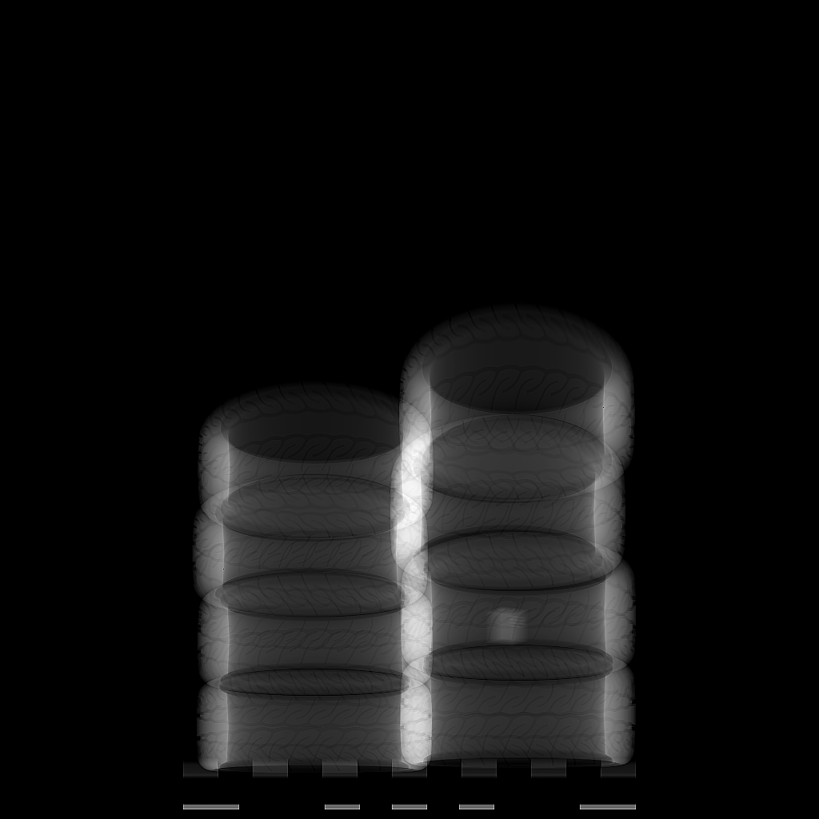

In [47]:
show_img(imgs[20], 0.8) # sample anomaly image

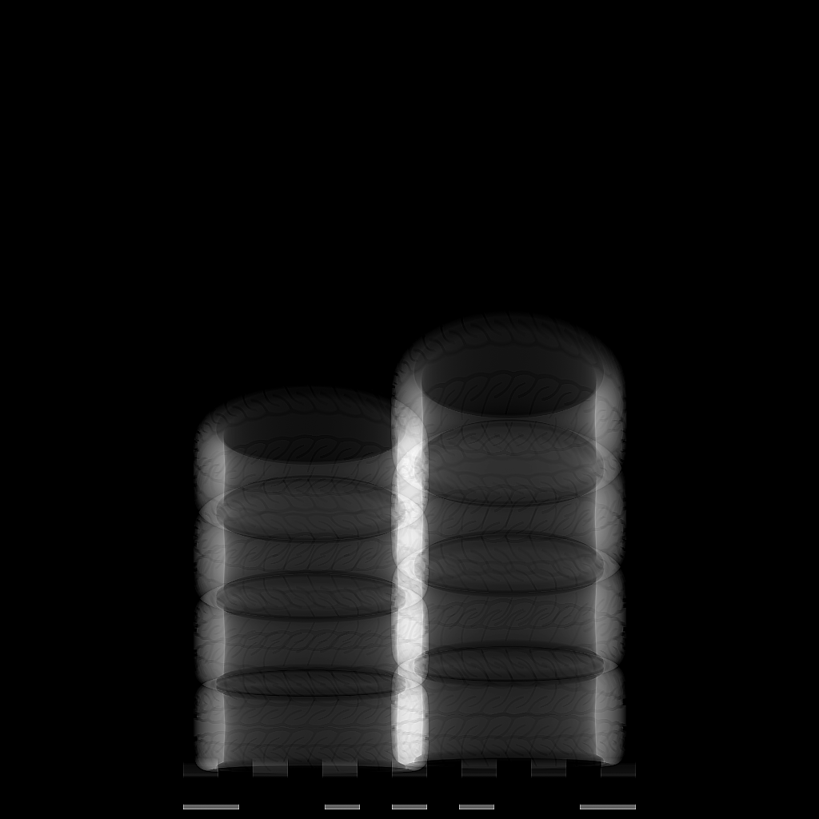

In [13]:
noa_images = [img for img in imgs if img.split("_")[2].lower()=="anomalyabsent"]
show_img(noa_images[18], scale = 0.8) # sample no anomaly image

In [14]:
Image.open(PATH + "/images/" + imgs[20]).size

(1024, 1024)

In [15]:
Image.open(PATH + "/images/" + imgs[20]).mode

'RGBA'

### III. Basic CNN

tensorflow tutorial: https://www.tensorflow.org/tutorials/images/cnn

In [16]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
tf.__version__
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
def convert_to_np(df: pd.DataFrame) -> np.ndarray: 
    """
    util to convert paths in dataframe to numpy arrays
    """
    return np.array([np.array(Image.open(PATH + "/images/" + row[0])) for _, row in df.iterrows()])


def create_df(imgtype: str, anomaly: bool): 
    """
    util to create dataframe from dictionary created above
    note: create wrapper to ensure limited subset of input with exception otherwise
    """
    df = type_dfs[imgtype]
    return df[df[0].str.contains("Absent")] if anomaly==False else df[~df[0].str.contains("Absent")]

In [18]:
# starting with apples images
type_dfs['Apples'].head()

,0
9,absorption_Apples_Anomaly1A20Q_P05_GravityJitt...
44,absorption_Apples_AnomalyAbsent_PNone_GravityJ...
47,absorption_Apples_Anomaly1A20Q_P05_GravityJitt...
55,absorption_Apples_Anomaly1A20Q_P05_GravityJitt...
57,absorption_Apples_Anomaly1A20Q_P01_GravityJitt...


In [19]:
anomalyappledf = create_df('Apples', True) # 72 images
noanomalyappledf = create_df('Apples', False) # 4 images

In [20]:
print(anomalyappledf[0][9])
test = np.array(Image.open(PATH + "/images/" + anomalyappledf[0][9]))
print(test)

absorption_Apples_Anomaly1A20Q_P05_GravityJitterOn_anomaly_only_view_0_200_high.png
[[[  0   0   0 255]
  [  0   0   0 255]
  [  1   1   1 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  1   1   1 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  1   1   1 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 ...

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]]


In [21]:
# prepare dataset for model
# split into train and test(for validation)
# train -> 58 anomalous, 2 non
# test  -> 14 anomalous, 2 non
# [NOTE] not using scikit-learn's train-test-split because tiny non-anomalous dataset size

train_split  = round(0.8*len(anomalyappledf))
test_split   = round(0.2*len(anomalyappledf))

train_images = convert_to_np(anomalyappledf[:train_split].append(noanomalyappledf[:2]))
test_images  = convert_to_np(anomalyappledf[train_split:].append(noanomalyappledf[2:]))
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels = np.asarray([1]*train_split + [0]*2)
test_labels  = np.asarray([1]*test_split + [0]*2)

In [22]:
print(len(train_images))
print(len(test_images))

60
16


In [31]:
# basic CNN architecture from tf tutorial linked above
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1024, 1024, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1022, 1022, 32)    1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 511, 511, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 509, 509, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 4064256)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
# [NOTE] look into adjusting model architecture (e.g., increase dense layers)

2022-03-09 15:56:14.335172: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-09 15:56:14.502041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 1.0638 - accuracy: 0.4667

2022-03-09 15:56:23.770730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 10s 4s/step - loss: 1.0638 - accuracy: 0.4667 - val_loss: 3.2883 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 7s 3s/step - loss: 0.8766 - accuracy: 0.9667 - val_loss: 0.9491 - val_accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 6s 3s/step - loss: 0.7592 - accuracy: 0.4667 - val_loss: 2.5783 - val_accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 6s 3s/step - loss: 1.4804 - accuracy: 0.5000 - val_loss: 5.8016 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 5s 3s/step - loss: 1.6228 - accuracy: 0.9667 - val_loss: 6.5149 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 5s 3s/step - loss: 1.7600 - accuracy: 0.9667 - val_loss: 5.8563 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 5s 3s/step - loss: 1.3731 - accuracy: 0.9667 - val_loss: 3.8635 - val_accuracy: 0.8750
Epoch 8/10
2/2 [==============================] - 6

1/1 - 0s - loss: 0.6867 - accuracy: 0.8750


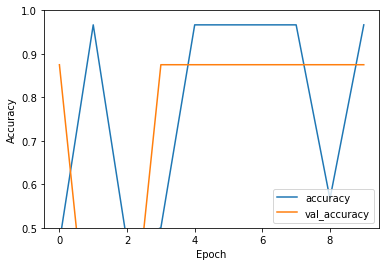

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [36]:
print(test_acc)

0.875


## Next steps from here
- Gitlab
- Write up algorithm to grab (2n)(2n) pixel blocks where n is defined as the length of the anomaly
- Read up on image partitioning techniques


## Other ideas
- Try other anomaly detection approaches
    - Autoencoder
    - KNN
- Explore getting additional images (particularly, non-anomalous images)
- Continue with CNN
    - Test CNN on full dataset
    - Tweak CNN hyperparameters